In [ ]:
import numpy as np
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from lac.localization.imu_recovery import (
    recover_rotation,
    recover_rotation_exact,
    recover_rotation_delta,
    recover_translation,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data


In [42]:
# data_path = "../../output/static_seed0/data_log.json"
data_path = "../../results/runs/map1_seed4_spiral_4.5_2.0_run2/data_log.json"
json_data = json.load(open(f"{data_path}"))

poses = []
imu_data = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))
    imu_data.append(np.array(frame["imu"]))

imu_data = np.array(imu_data)
initial_pose = np.array(json_data["initial_pose"])

gt_translations = np.zeros((len(poses), 3))
for i in range(len(poses)):
    gt_translations[i] = poses[i][:3, 3]

dt = 0.05
times = np.arange(0, len(imu_data) * dt, dt)

### Initialization


In [43]:
"""True initialization"""
# start_idx = 1
# poses_crop = poses[start_idx:]
# R_prev = poses[start_idx][:3, :3]
# # t_prev_prev = poses[start_idx - 1][:3, 3]
# t_prev_prev = poses[start_idx][:3, 3]
# t_prev = poses[start_idx][:3, 3]

"""Provided initialization"""
start_idx = 0
poses_crop = poses[start_idx:]
R_prev = initial_pose[:3, :3]
t_prev_prev = initial_pose[:3, 3]
t_prev = initial_pose[:3, 3]

In [44]:
imu_rotations = []
imu_rotations.append(R_prev)

imu_translations = []
imu_translations.append(t_prev)

for i in tqdm(range(start_idx + 1, len(poses))):
    # Rotation recovery
    omega = imu_data[i, 3:]
    # R_curr = recover_rotation_exact(R_prev, omega, dt)
    R_curr = recover_rotation(R_prev, omega, dt)
    imu_rotations.append(R_curr)
    R_prev = R_curr

    # Translation recovery
    a = imu_data[i, :3]
    t_curr = recover_translation(t_prev_prev, t_prev, R_curr, a, dt)
    imu_translations.append(t_curr)
    t_prev_prev = t_prev
    t_prev = t_curr

100%|██████████| 15799/15799 [00:00<00:00, 83644.45it/s]


Average error in degrees
[0.04579499 0.09799353 0.1257857 ]


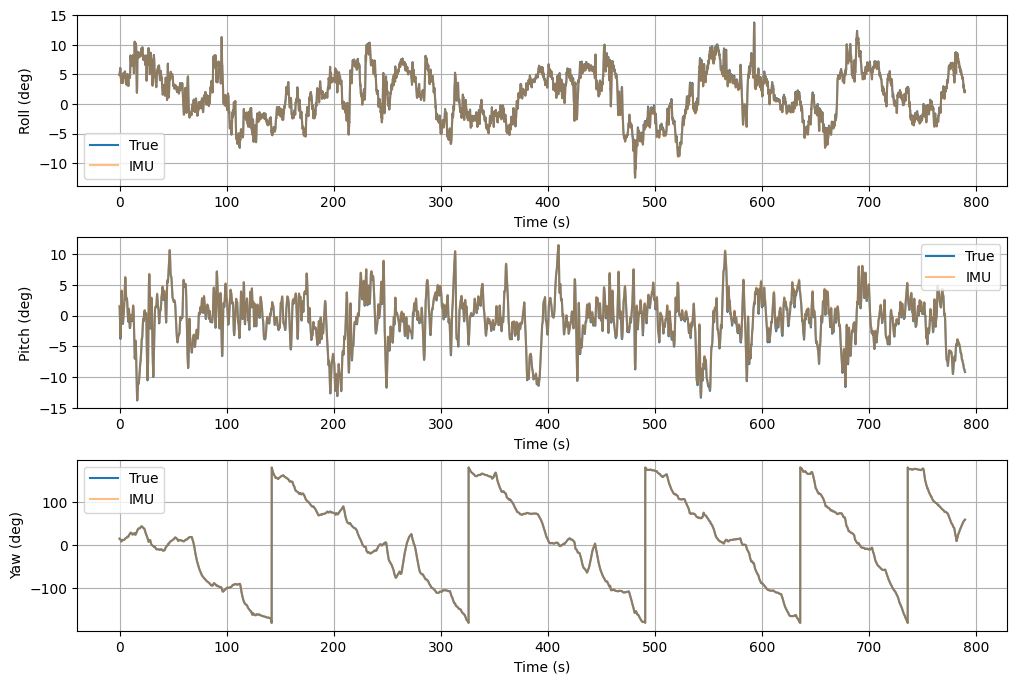

In [45]:
gt_rotations_euler = np.zeros((len(poses_crop), 3))
imu_rotations_euler = np.zeros((len(poses_crop), 3))

for i in range(len(poses_crop)):
    gt_rotations_euler[i] = Rotation.from_matrix(poses_crop[i][:3, :3]).as_euler(
        "xyz", degrees=True
    )
    imu_rotations_euler[i] = Rotation.from_matrix(imu_rotations[i]).as_euler("xyz", degrees=True)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
pos_labels = ["Roll (deg)", "Pitch (deg)", "Yaw (deg)"]
for i in range(3):
    ax = axes[i]
    ax.plot(times[start_idx:], gt_rotations_euler[:, i], label="True")
    ax.plot(times[start_idx:], imu_rotations_euler[:, i], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

print("Average error in degrees")
print(np.mean(np.abs(gt_rotations_euler - imu_rotations_euler), axis=0))

Average error in meters
[44.5428965   9.75418569  2.29792354]


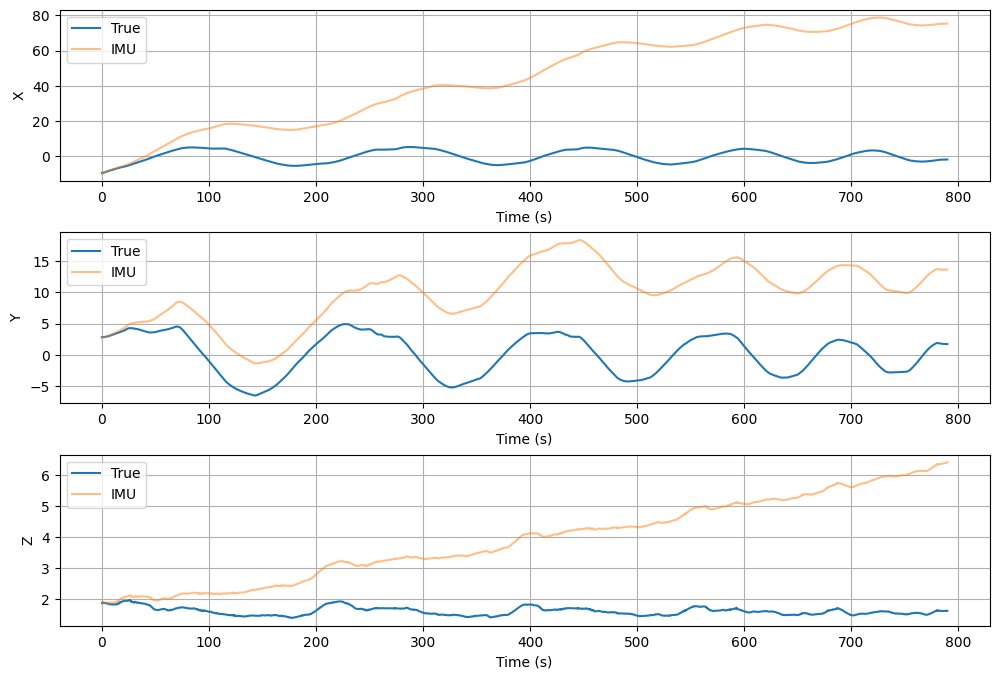

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
pos_labels = ["X", "Y", "Z"]

imu_translations = np.array(imu_translations)

gt_translations = np.zeros((len(poses_crop), 3))
for i in range(len(poses_crop)):
    gt_translations[i] = poses_crop[i][:3, 3]

for i in range(3):
    ax = axes[i]
    ax.plot(times[start_idx:], gt_translations[:, i], label="True")
    ax.plot(times[start_idx:], imu_translations[:, i], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

print("Average error in meters")
print(np.mean(np.abs(gt_translations - imu_translations), axis=0))

In [47]:
delta_rotations_imu = []
delta_translations_imu = []
delta_rotations_gt = []
delta_translations_gt = []

for i in range(1, len(poses)):
    delta_rotations_imu.append(imu_rotations[i] @ imu_rotations[i - 1].T)
    delta_translations_imu.append(imu_translations[i] - imu_translations[i - 1])
    delta_rotations_gt.append(poses[i][:3, :3] @ poses[i - 1][:3, :3].T)
    delta_translations_gt.append(poses[i][:3, 3] - poses[i - 1][:3, 3])

delta_rotations_imu = np.array(delta_rotations_imu)
delta_translations_imu = np.array(delta_translations_imu)
delta_rotations_gt = np.array(delta_rotations_gt)
delta_translations_gt = np.array(delta_translations_gt)

In [50]:
from lac.util import rmse, rotation_matrix_error

rmse(delta_translations_gt, delta_translations_imu)

0.0038557302874190993

In [56]:
rotation_errors = [
    rotation_matrix_error(R1, R2) for R1, R2 in zip(delta_rotations_gt, delta_rotations_imu)
]
np.sqrt(np.mean(np.array(rotation_errors) ** 2))

0.000852860992225215

Recover deltas


In [ ]:
def recover_rotation_delta(omega, dt):
    """Given angular velocity, recover rotation delta"""